<a href="https://colab.research.google.com/github/ChicagoPark/chicago_work/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data and AI Project `by Youngil Park`

##    전체적 모델링 흐름

*   본 프로젝트 분류를 위해 여러 차례 훈련했던 MobileNetV2 에서 Convolution layer 을 Feature extractor 으로 활용하고, 이에 뒤 뉴럴네트워크 연산 부분의 노드 구성을 달리하여 10개의 모델을 준비한다.

*   "---" 를 컴퓨터 계산적으로 증명된 Hyper parameter 를 사용하기위해 Hyperparameter tuning 기법을 활용한다.

## 본 Colab 모델링 목차


1.   필요한 라이브러리 및 데이터 전처리
2.   feature extractor 모델을 가져와서, 특징 추출기 자리에 넣고 freezing 하기
3. 모델에 Opimizer, Loss 등을 명시하고, 훈련을 수행
4. TensorBoard 를 활용한 훈련결과 시각화
5. Test Set 에 대해 4X4 로 보여주는 결과

## 본 Colab 부록


1.   Hypertuning 진행
2.   freezing 방식이 아닌, 최초 모델 정의법


In [ ]:
%%capture
# 과제 수행에 기본이 되는 라이브러리
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os
import scipy
import keras

# Data Augmentation(Image transformations) 을 하기 위해 필요한 모듈
from keras.preprocessing.image import ImageDataGenerator 

# 모델구조를 그리기 위한 모듈
from tensorflow.keras.utils import plot_model
# 하이퍼 파라미터 튜닝을 위한 라이브러리
! pip install keras_tuner
import keras_tuner as kt
import shutil
# 훈련결과 Plotting 을 위한 라이브러리
import matplotlib.pyplot as plt

In [ ]:
# Figure out GPU is available or not on Colab
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Data Process


1.   Colab 환경에 training_data 라고 하는 디렉터리 생성
2.   구글 드라이브에서의 zip 을 풀고, 해당 디렉터리로 이동
3. 훈련을 위해 데이터를 손쉽게 처리할 수 있는 ImageDataGenerator 과 flow from directory 활용



In [ ]:
# Colab 상의 훈련용 데이터 디렉터리 정리
!mkdir training_data
%cd training_data/
!mkdir '0. stone'
!mkdir '1. pothole'
!mkdir '2. filled'
%cd ..

/content/training_data
/content


In [ ]:
%%capture
# AI hub, Web, KITTI, Personal data, Kaggle, IMLab 데이터 총집합 압축파일을 불러온다.
# Google Drive 에서 바로 받아오면 data reading 속도가 너무 느리므로, Colab environment 에 설치하는 것이 매우 종요하다.

!gdown --id 1RpWlAvmQlDUfO2XBGlao0INSb-USL7DE --out 'semi_training_balanced_data.zip'
!unzip 'semi_training_balanced_data.zip' -d 'semi_training_balanced_data'

# training_data 폴더로 zip 해제한 모든 파일을 정리한다.
!mv /content/semi_training_balanced_data/semi_training_balanced_data/'0. stone'/* /content/training_data/'0. stone'
!mv /content/semi_training_balanced_data/semi_training_balanced_data/'1. pothole'/* /content/training_data/'1. pothole'
!mv /content/semi_training_balanced_data/semi_training_balanced_data/'2. filled'/* /content/training_data/'2. filled'

In [ ]:
# 정리된 데이터의 개수를 확인
# 1. 기본 뿌리 디렉터리와 검증데이터 경로를 가져온다
base_path = os.path.abspath('/content/training_data')
print(base_path)

# 2. 데이터 경로를 지정을 해준다.
no_pothole_dir = os.path.join(base_path, '0. stone')
pothole_dir = os.path.join(base_path, '1. pothole')
filled_dir = os.path.join(base_path, '2. filled')

# 3. 데이터 셋의 개수를 카운팅한다.
num_no_pothole = len(os.listdir(no_pothole_dir))
num_pothole_dir = len(os.listdir(pothole_dir))
num_filled_dir = len(os.listdir(filled_dir))

total_data = num_no_pothole + num_pothole_dir + num_filled_dir

print(f'정상도로 : {num_no_pothole} 개 , 팟홀도로 : {num_pothole_dir}, 보수도로 : {num_filled_dir}')

print(f'Total Data 개수 : {total_data}')

/content/training_data
정상도로 : 6787 개 , 팟홀도로 : 6815, 보수도로 : 6631
Total Data 개수 : 20233


In [ ]:
# Train set 과 Validation set 을 나누며, Data Augmentation 작업 또한 추가시킨다.
train_image_generator = ImageDataGenerator(rescale=1./255,                                     
      rotation_range=7,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.15)

# Validation set 은 데이터 증식 기법을 적용하지 않기에 rescaling 작업만 수행해준다.
validation_image_generator = ImageDataGenerator(rescale=1./255,
                                                validation_split=0.15)

# Batch size 와 Epoch, 이미지 사이즈를 정의해준다.
train_batch_size = 128
val_batch_size = 128
epochs = 15
IMG_HEIGHT = 320
IMG_WIDTH = 320

/content/training_data
정상도로 : 6787 개 , 팟홀도로 : 6815, 보수도로 : 6631
Total Data 개수 : 20233


In [ ]:
# 앞서 정의한 ImageDataGenerator 를 적용하기위한 코드
# seed 를 train_dataset 과, val_dataset 에 대해 동일하게 설정하여, 동일한 path 에서의
# 중복된 데이터가 서로에게 포함되지 않도록 처리한다.
train_data_gen = train_image_generator.flow_from_directory(batch_size=train_batch_size,
                                                           directory=base_path,
                                                           seed = 22,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           subset='training',
                                                           class_mode='categorical')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=val_batch_size,
                                                           directory=base_path,
                                                           seed = 22,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           subset='validation',
                                                           class_mode='categorical')
# training set 이 몇개인지, validation set 이 몇개인지 확인목적
train_num = train_data_gen.samples 
val_num = val_data_gen.samples   

# Basic Model Definition

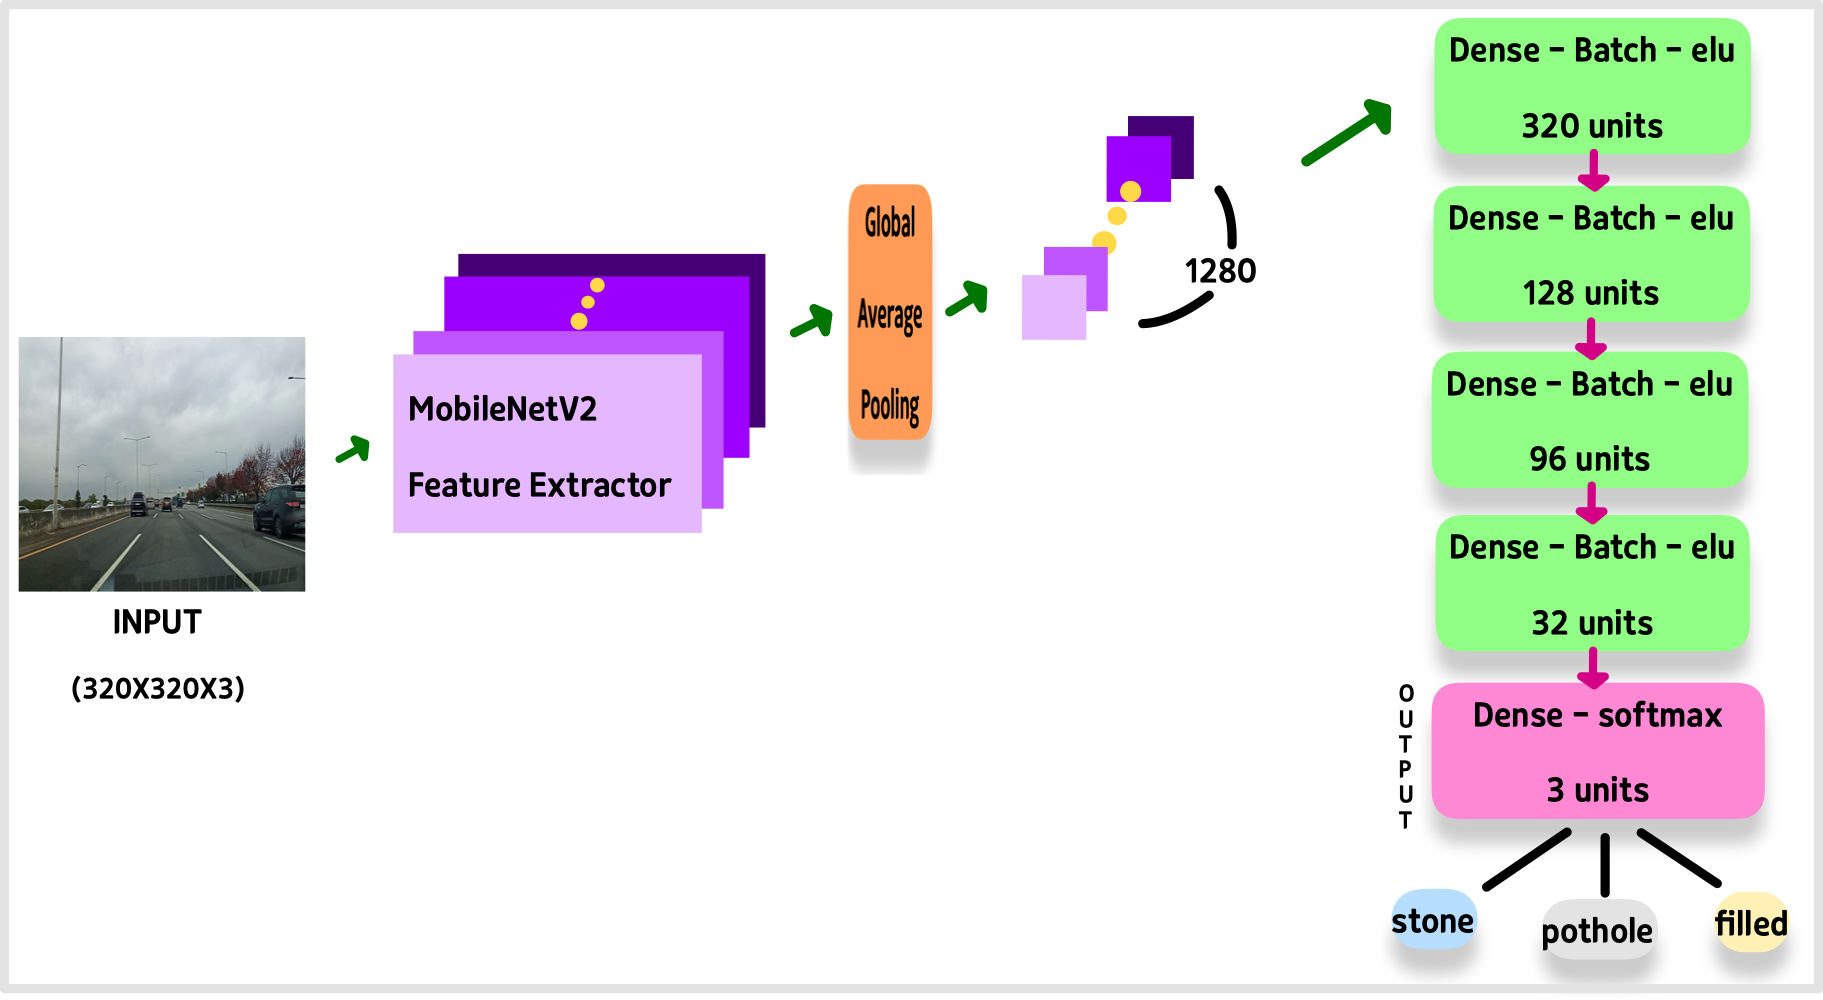

In [ ]:
# Transfer learning 을 위한 모델을 keras 에서 불러와준다. width multiplier 를 0.35로 설정하고, imagenet 데이터에 대해 훈련된 가중치를 가져온다.
base_model = tf.keras.applications.MobileNetV2(
        input_shape=None,
        alpha=0.35,
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        pooling=None
      )
base_model.trainable = True

# Classification 을 위한 층을 쌓아준다.
# 중간 activation function : elu 
# 마지막 층 acitivation function : softmax (for multi-classification(3))
inputs = keras.Input(shape=(320, 320, 3))
x = base_model(inputs, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(units=320,activation=None)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation="elu")(x)
x = tf.keras.layers.Dense(units=128,activation=None)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation="elu")(x)
x = tf.keras.layers.Dense(units=96,activation=None)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation="elu")(x)
x = tf.keras.layers.Dense(units=32,activation=None)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation="elu")(x)
outputs = keras.layers.Dense(3, activation='softmax')(x)

new_model = keras.Model(inputs=inputs, outputs=outputs)

new_model.summary()

plot_model(new_model, show_shapes=True)

Found 4497 images belonging to 3 classes.
Found 792 images belonging to 3 classes.


# Training Process


1.   Optimizer 정의
2.   비용함수 정의
3. Best Model Saving 등 유용한 callback 함수 정의
4. 훈련 결과 시각화


In [ ]:
# optimizer 를 정의해주고,아래에 있는 optimizer 들은 후보군들이다.
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, centered=True)
#opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
#opt = tf.keras.optimizers.Nadam(learning_rate=0.00166, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")

# 사용할 모델에서 어떤 Loss function 과 Optimizer 를 사용할지 명시해준다.
new_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics = ['accuracy'])
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/빅데이터및AI/Model/model_13.h5',
    # save_weights_only 를 False 로 설정하여 모델에 대한 모든 정보를 저장할 수 있도록 한다.
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
]

In [ ]:
# 본격적으로 훈련을 시작하는 단계
history = new_model.fit_generator(
    train_data_gen,
    steps_per_epoch=train_num//train_batch_size,
    epochs=10,
    validation_data = val_data_gen,
    validation_steps = val_num//val_batch_size,
    # 앞서 정의한 callback 기능을 사용하기위한 부분
    callbacks=[my_callbacks])

In [ ]:
# Training 결과 시각화를 위한 코드
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 효율적 프로젝트 수행을 위해 훈련 시스템

##### 모델을 정의하고나면, 이후에는 훈련만 시키면 된다. 따라서 위 모델링 코드에서 저장한 모델만 불러와서 훈련을 계속해서 진행할 수 있도록 한다.

In [ ]:
# Google Drive 에서 모델을 로딩해온다.
model_1 = keras.models.load_model('/content/drive/MyDrive/빅데이터및AI/Model/model_1.h5')
model_2 = keras.models.load_model('/content/drive/MyDrive/빅데이터및AI/Model/model_2.h5')
model_3 = keras.models.load_model('/content/drive/MyDrive/빅데이터및AI/Model/model_3.h5')
model_4 = keras.models.load_model('/content/drive/MyDrive/빅데이터및AI/Model/model_4.h5')
model_5 = keras.models.load_model('/content/drive/MyDrive/빅데이터및AI/Model/model_5.h5')

# 모델별 Callback 함수를 정의한다. 설명은 앞선 설명과 중복된다.
my_callbacks1 = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/model_1.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
]
my_callbacks2 = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/model_2.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
]
my_callbacks3 = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/model_3.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
]
my_callbacks4 = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/model_4.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
]
my_callbacks5 = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/model_5.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
]
# 모델별 훈련을 진행하는 코드를 가져온다.
history1 = model_1.fit_generator(
    train_data_gen,
    steps_per_epoch=train_num//train_batch_size,
    epochs=10,
    validation_data = val_data_gen,
    validation_steps = val_num//val_batch_size,
    callbacks=[my_callbacks1])
history2 = model_2.fit_generator(
    train_data_gen,
    steps_per_epoch=train_num//train_batch_size,
    epochs=10,
    validation_data = val_data_gen,
    validation_steps = val_num//val_batch_size,
    callbacks=[my_callbacks2]
history3 = model_3.fit_generator(
    train_data_gen,
    steps_per_epoch=train_num//train_batch_size,
    epochs=10,
    validation_data = val_data_gen,
    validation_steps = val_num//val_batch_size,
    callbacks=[my_callbacks3]
history4 = model_4.fit_generator(
    train_data_gen,
    steps_per_epoch=train_num//train_batch_size,
    epochs=10,
    validation_data = val_data_gen,
    validation_steps = val_num//val_batch_size,
    callbacks=[my_callbacks4]
history5 = model_5.fit_generator(
    train_data_gen,
    steps_per_epoch=train_num//train_batch_size,
    epochs=10,
    validation_data = val_data_gen,
    validation_steps = val_num//val_batch_size,
    callbacks=[my_callbacks5]

# `Model Freezing`

In [ ]:
freezing_extractor = keras.models.load_model('/content/drive/MyDrive/빅데이터및AI/Model/freezing_extractor.h5')

In [ ]:
# first index is about feature extractor (1: feature extractor 얼리는거 3,4 는 상위층 !)
new_model.layers[1].set_weights(feature_extractor.layers[1].get_weights())
new_model.layers[3].set_weights(feature_extractor.layers[3].get_weights())
new_model.layers[4].set_weights(feature_extractor.layers[4].get_weights())

# 특징추출기에 해당하는 CNN 을 freezing 시킨다.
new_model.layers[1].trainable = False
new_model.layers[3].trainable = False
new_model.layers[4].trainable = False

new_model.summary()

base_model = tf.keras.applications.MobileNetV2(
        input_shape=None,
        alpha=.35,
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        pooling=None
      )
    # 해당 층의 매개변수는 그대로 사용하기 위해서 freezing 을 한다.
base_model.trainable = True

inputs = keras.Input(shape=(320, 320, 3))
x = base_model(inputs, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(units=320,activation=None)(x)
x = tf.keras.layers.BatchNormalization()(x)
#x = keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Activation(activation="elu")(x)
x = tf.keras.layers.Dense(units=256,activation=None)(x)
x = tf.keras.layers.BatchNormalization()(x)
#x = keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Activation(activation="elu")(x)
x = tf.keras.layers.Dense(units=128,activation=None)(x)
x = tf.keras.layers.BatchNormalization()(x)
#x = keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Activation(activation="elu")(x)
x = tf.keras.layers.Dense(units=32,activation=None)(x)
x = tf.keras.layers.BatchNormalization()(x)
#x = keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Activation(activation="elu")(x)
outputs = keras.layers.Dense(3, activation='softmax')(x)

freezing_model = keras.Model(inputs=inputs, outputs=outputs)

# 로딩해온 모델에서, MobileNetV2 부분만을 얼린다.
freezing_model.layers[1].set_weights(feature_extractor.layers[1].get_weights())
freezing_model.layers[1].trainable = False
freezing_model.summary()

# 사용할 Optimizer 를 정의한다.
opt = tf.keras.optimizers.RMSprop(learning_rate=0.002, centered=True)

freezing_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics = ['accuracy'])
freezing_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/freezing_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
]

freezing_history = freezing_model.fit_generator(
    train_data_gen,
    steps_per_epoch=train_num//train_batch_size,
    epochs=10,
    validation_data = val_data_gen,
    validation_steps = val_num//val_batch_size,
    #check call back name
    callbacks=[freezing_callbacks])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 320, 320, 3)]     0         
                                                                 
 mobilenetv2_0.35_224 (Funct  (None, None, None, 1280)  410208   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_18 (Dense)            (None, 320)               409920    
                                                                 
 batch_normalization_14 (Bat  (None, 320)              1280      
 chNormalization)                                                
                                                           

In [ ]:
# decision boundary
# https://www.machinecurve.com/index.php/2019/10/11/how-to-visualize-the-decision-boundary-for-your-keras-model/

# `Hyperparam Tuning : 최적의 activation fucntion 찾기`

In [ ]:
# Create base model
# input_tensor 는 내가 쓰고 싶은 입력크기
# input_shape 는 모델이 가지는 입력크기를 말하는듯
# [1] MobileNetV2 모델 
''''''
def build_model(hp):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=None,
        alpha=0.35,
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        pooling=None
      )
    base_model.trainable = True

    act_func = hp.Choice("act_func", ["relu", "selu", "elu", "softplus"])

    inputs = keras.Input(shape=(320, 320, 3))
    x = base_model(inputs, training=True)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(units=320,activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation=act_func)(x)
    x = tf.keras.layers.Dense(units=128,activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation=act_func)(x)
    x = tf.keras.layers.Dense(units=96,activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation=act_func)(x)
    x = tf.keras.layers.Dense(units=32,activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation=act_func)(x)
    outputs = keras.layers.Dense(3, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = 3e-4
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), # 교차엔트로피로 구성
              metrics=['accuracy'])
    
    return model


In [ ]:
# Keras_tuner 가 정상 작동하는지 확인
build_model(kt.HyperParameters())

ValueError: ignored

In [ ]:
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=4,
    executions_per_trial=1,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
act_func (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'selu', 'elu', 'softplus'], 'ordered': False}


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

tuner.search(train_data_gen,validation_data=val_data_gen, epochs=7, callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")])

# 텐서보드 출력
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_logs

Trial 4 Complete [00h 42m 50s]
val_accuracy: 0.7362204790115356

Best val_accuracy So Far: 0.7532808184623718
Total elapsed time: 02h 52m 10s

Search: Running Trial #5

Hyperparameter    |Value             |Best Value So Far 
act_func          |relu              |relu              

Epoch 1/7
136/136 [==============================] - 371s 3s/step - loss: 0.4704 - accuracy: 0.8218 - val_loss: 0.7385 - val_accuracy: 0.6877
Epoch 2/7
136/136 [==============================] - 360s 3s/step - loss: 0.2693 - accuracy: 0.9052 - val_loss: 0.7782 - val_accuracy: 0.6955
Epoch 3/7
 29/136 [=====>........................] - ETA: 4:29 - loss: 0.2113 - accuracy: 0.9278

KeyboardInterrupt: ignored

In [ ]:
tuner.results_summary()

Results summary
Results in my_dir/helloworld
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 2
units_0: 320
units_1: 384
Score: 0.75
Trial summary
Hyperparameters:
num_layers: 2
units_0: 160
units_1: 64
Score: 0.75
Trial summary
Hyperparameters:
num_layers: 2
units_0: 352
units_1: 448
Score: 0.6666666865348816
Trial summary
Hyperparameters:
num_layers: 3
units_0: 160
units_1: 288
units_2: 64
Score: 0.6666666567325592


In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [ ]:
tf.debugging.set_log_device_placement(False)